In [13]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from quimb.tensor.tensor_1d import expec_TN_1D

N = 6
times = np.linspace(0, 10.0, 200)

hx, hy = 0.0, 0.0
Jx, Jy, Jz = 1.0, 0.0, 0.0
hz = [(np.random.uniform(-8.0, 8.0) + 4) / 2 for _ in range(N)]
alpha = 1.13

binary = ''.join([str((i+1) % 2) for i in range(N)])
print(f'Initial state: |{binary}>')
psi0 = qtn.MPS_computational_state(binary)
psi0.show()

max_bond = 14
cutoff = 1e-15

Initial state: |101010>
 1 1 1 1 1 
>─>─>─>─>─●
│ │ │ │ │ │


In [14]:
hz = [3.5002456640243587, 2.1348410418662898, 3.7939020763471074, 1.8076311318070069, 4.6941678763876196, 1.16944650425613]

In [15]:
XX = qu.kron(qu.pauli('X'), qu.pauli('X'))
YY = qu.kron(qu.pauli('Y'), qu.pauli('Y'))
ZZ = qu.kron(qu.pauli('Z'), qu.pauli('Z'))

H1 = {}
for i in range(N):
    H1[i] = hx * qu.pauli('X') \
          + hy * qu.pauli('Y') \
          + hz[i] * qu.pauli('Z')

l = 1
H2 = {}
for i in range(N):
    for j in range(i+1, min(i+l+1, N)):
        H2[(i, j)] = Jx / (np.abs(i-j)**alpha) * XX \
                   + Jy / (np.abs(i-j)**alpha) * YY \
                   + Jz / (np.abs(i-j)**alpha) * ZZ

H = qtn.LocalHam1D(L=N, H2=H2, H1=H1, cyclic=False)

tebd = qtn.TEBD(psi0, H)
tebd.split_opts['max_bond'] = max_bond
tebd.split_opts['cutoff'] = cutoff

mz_t_j = []
mz_t_total = []

for t_idx, psit in enumerate(tebd.at_times(times, tol=1e-3)):
    mzs = []
    bra = psit.H
    
    for j in range(N):
        sz_applied = psit.gate(qu.pauli('Z'), j, contract=True)
        mzs.append(expec_TN_1D(bra, sz_applied).real)
    
    mz_t_j.append(mzs)
    mz_t_total.append(sum(mzs))

mz_t_j = np.array(mz_t_j)
mz_t_total = np.array(mz_t_total)

corr_zz = np.zeros((len(times), N, N), dtype=np.complex128)

for j in tqdm(range(N), unit="j"):
    psi0_zj = psi0.gate(qu.pauli('Z'), j, contract=True)

    tebd = qtn.TEBD(psi0, H)
    tebd.split_opts['max_bond'] = max_bond
    tebd.split_opts['cutoff'] = cutoff

    tebd_z = qtn.TEBD(psi0_zj, H)
    tebd_z.split_opts['max_bond'] = max_bond
    tebd_z.split_opts['cutoff'] = cutoff

    for idx, t in enumerate(times):
        if idx > 0:
            tebd.update_to(t, dt=times[idx]-times[idx-1], progbar=False)
            tebd_z.update_to(t, dt=times[idx]-times[idx-1], progbar=False)

        for i in range(N):
            zi_psi_zj = tebd_z.pt.gate(qu.pauli('Z'), i, contract=True)
            corr_zz[idx, i, j] = expec_TN_1D(tebd.pt.H, zi_psi_zj).real

D = 0.5 * (1 - N**(-1) * np.trace(corr_zz, axis1=1, axis2=2)).real

100%|██████████| 6/6 [00:21<00:00,  3.52s/j]


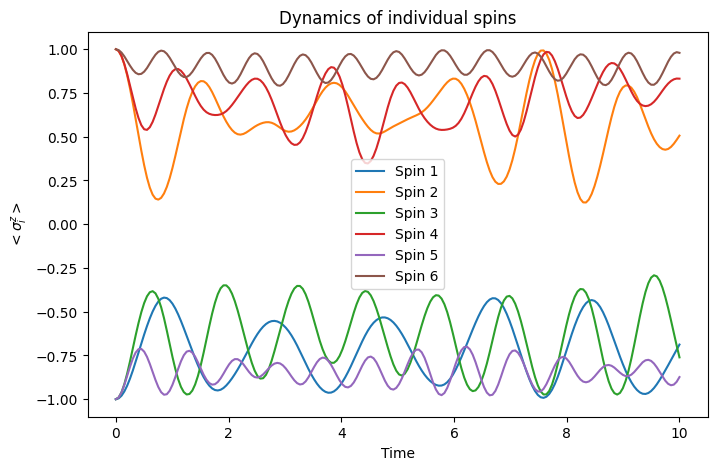

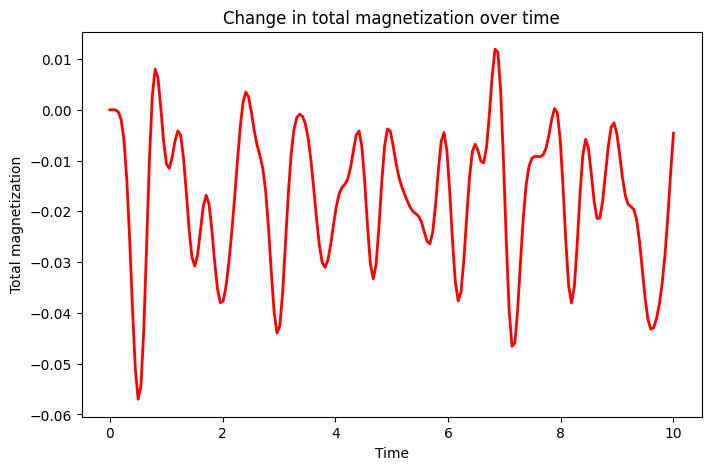

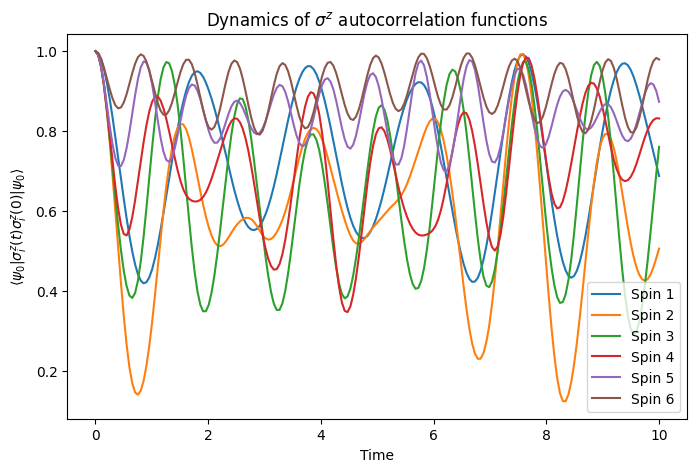

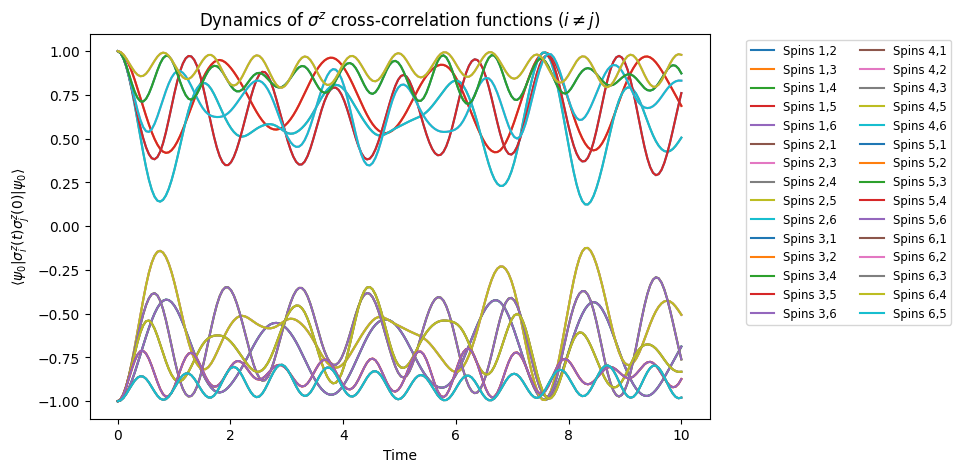

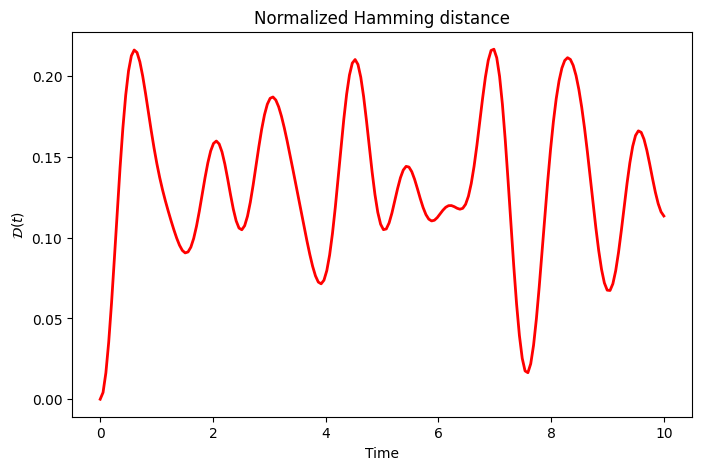

In [16]:
plt.figure(figsize=(8, 5))
for j in range(N):
    plt.plot(times, mz_t_j[:, j], label=f'Spin {j+1}')
plt.xlabel('Time')
plt.ylabel(r'$<\sigma^z_i>$')
plt.legend()
plt.title('Dynamics of individual spins')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(times, mz_t_total, 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Total magnetization')
plt.title('Change in total magnetization over time')
plt.show()

plt.figure(figsize=(8, 5))
for i in range(N):
    plt.plot(times, np.real(corr_zz[:, i, i]), label=f'Spin {i+1}')
plt.xlabel('Time')
plt.ylabel(r'$\langle \psi_0 | \sigma^z_i(t)\sigma^z_i(0) | \psi_0 \rangle$')
plt.legend()
plt.title(r'Dynamics of $\sigma^z$ autocorrelation functions')
plt.show()

plt.figure(figsize=(8, 5))
for i in range(N):
    for j in range(N):
        if i != j:
            plt.plot(times, np.real(corr_zz[:, i, j]), label=f'Spins {i+1},{j+1}')
plt.xlabel('Time')
plt.ylabel(r'$\langle \psi_0 | \sigma^z_i(t)\sigma^z_j(0) | \psi_0 \rangle$')
plt.title(r'Dynamics of $\sigma^z$ cross-correlation functions ($i \neq j$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(times, D, 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel(r'$\mathcal{D}(t)$')
plt.title('Normalized Hamming distance')
plt.show()